Spring 2023
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

CIE 555, Neural Networks and Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center">Project #3</h1>
<h1 align="center"> Image De-noising using convolutional Auotoencoders </h1>

---

# Denoising Autoencoder



Autoencoders can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of some noisy images generated and the denoised images.

![alt text](https://static.packt-cdn.com/products/9781788399906/graphics/f9b44226-662e-43a1-aaa8-f9f952d8ce60.png)



In [ ]:
import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

## Dataset

#Fashion MNIST Dataset

a dataset comprising of 28×28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category. The training set has 60,000 images and the test set has 10,000 images.

Each training and test example is assigned to one of the following labels:

0: T-shirt/top

1: Trouser

2: Pullover

3: Dress

4: Coat

5: Sandal

6: Shirt

7: Sneaker

8: Bag

9: Ankle boot

Each row is a separate image
Column 1 is the class label.
Remaining columns are pixel numbers (784 total).
Each value is the darkness of the pixel (1 to 255)

In [ ]:
# Split dataset into training and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

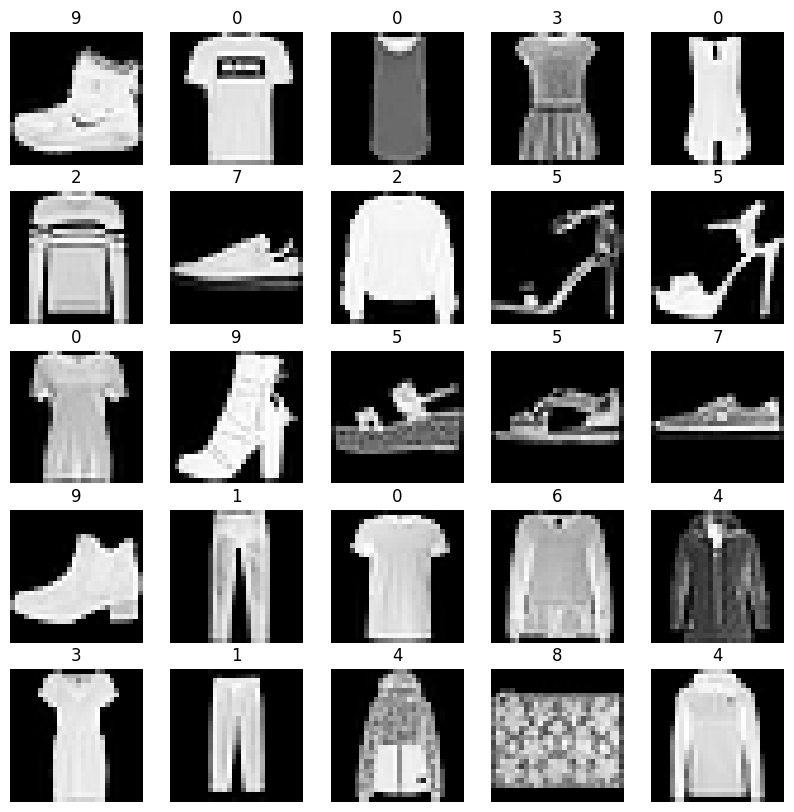

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i], cmap='Greys_r')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

###Flattening and normalizing images


In [ ]:
image_size = X_train.shape[1]
X_train = np.reshape(X_train, [-1, image_size, image_size, 1])
X_test = np.reshape(X_test, [-1, image_size, image_size, 1])

## Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
# summarize the shape of the dataset
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28, 1) (10000,)


In [ ]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.3
noise = np.random.normal(loc=0.5, scale=0.3, size=X_train.shape)
x_train_noisy = X_train + noise
noise = np.random.normal(loc=0.5, scale=0.3, size=X_test.shape)
x_test_noisy = X_test + noise

# Clip the images to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


## Model

We build our encoder using a stack of convolutional layers with maxpooling that successively reduces the image size by 2. The latent-space representation is the compressed form of our data.

In [ ]:
# First build the Encoder Model
input = Input(shape=(28, 28, 1), name='encoder_input')

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)


Next, we need to build our decoder.

We will use `Conv2DTranspose` layers, whose purpose is to increase the volume size. Transposed convolution layers are used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger output in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 feature map in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 feature map in a transposed convolution layer. Checkout Keras transposed convolution layer module [`Conv2DTranspose`](https://keras.io/layers/convolutional/) or this [Tutorial](https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967).


In [ ]:
# Decoder
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x) # Why?

Finally, we construct the autoencoder.

In [ ]:
# Autoencoder
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 32)       9248

## Training our Autoencoder

In [ ]:
autoencoder.fit(x = x_train_noisy,
                y = X_train,
                validation_split = 0.2,
                # validation_date = (x_test, x_test_noisy),
                epochs=100,
                shuffle = True,
                batch_size=128)

Epoch 1/100
375/375 [==============================] - 5s 8ms/step - loss: 0.3569 - val_loss: 0.3078
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 0.3018 - val_loss: 0.3018
Epoch 3/100
375/375 [==============================] - 4s 11ms/step - loss: 0.2962 - val_loss: 0.2955
Epoch 4/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2930 - val_loss: 0.2928
Epoch 5/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2907 - val_loss: 0.2911
Epoch 6/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2890 - val_loss: 0.2899
Epoch 7/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2876 - val_loss: 0.2886
Epoch 8/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2863 - val_loss: 0.2873
Epoch 9/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2852 - val_loss: 0.2862
Epoch 10/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2844 - val_l

## Results

Here we are adding noise to the test images and passing them through the autoencoder.

313/313 [==============================] - 1s 2ms/step


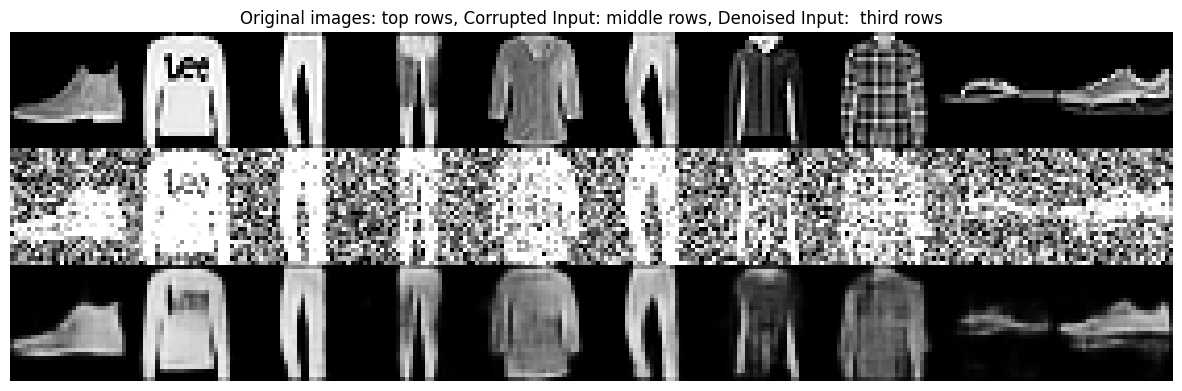

In [ ]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 10 corrupted and denoised images
rows, cols = 1, 10
num = rows * cols
imgs = np.concatenate([X_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

# References:



1.   https://blog.keras.io/building-autoencoders-in-keras.html

2.   https://www.v7labs.com/blog/autoencoders-guide

3.   https://keras.io/examples/vision/autoencoder/



